# Data cubes with ODC-STAC

In this notebook we show how [odc-stac](https://odc-stac.readthedocs.io/en/latest/?badge=latest) can be employed to retile and stack satellite images in what are sometimes referred to as "data cubes".

We use the administrative boundaries of the island of Rhodes to define our area of interest (AoI): 

In [1]:
import geopandas
rhodes = geopandas.read_file('rhodes_130524.gpkg')
bbox = rhodes.total_bounds

We search for satellite images including the AoI in the [Sentinel-2 L2A](https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1/collections/sentinel-2-l2a) collection that is indexed in the [Earth Search STAC API](https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1/): 

In [2]:
import pystac_client

api_url = "https://earth-search.aws.element84.com/v1"
collection_id = "sentinel-2-c1-l2a"

client = pystac_client.Client.open(api_url)
search = client.search(
    collections=[collection_id],
    datetime="2023-07-01/2023-08-31",
    bbox=bbox
)

item_collection = search.item_collection()

[odc-stac](https://odc-stac.readthedocs.io/en/latest/?badge=latest) can ingest directly our search results and create a Xarray DataSet object from the STAC metadata that are present in the `item_collection`. By specifying `groupby='solar_day'`, odc-stac automatically groups and merges images corresponding to the same date of acquisition. `chunks={...}` sets up the resulting data cube using Dask arrays, thus enabling lazy loading (and further operations). `use_overviews=True` tells odc-stac to direcly load lower-resolution versions of the images from the overviews, if these are available in Cloud Optimized Geotiffs (COGs). We set the resolution of the data cube using the `resolution` argument, and define the Aoi using the bounding box (`bbox`).

In [3]:
import odc.stac
ds = odc.stac.load(
    item_collection,
    groupby='solar_day',
    chunks={'x': 2048, 'y': 2048},
    use_overviews=True,
    resolution=20,
    bbox=rhodes.total_bounds,
)

odc-stac builds a data cube representation from all the relevant files linked in `item_collection` as a Xarray DataSet: 

In [4]:
ds

<xarray.Dataset> Size: 7GB
Dimensions:      (y: 3255, x: 2567, time: 25)
Coordinates:
  * y            (y) float64 26kB 4.035e+06 4.035e+06 ... 3.97e+06 3.97e+06
  * x            (x) float64 21kB 5.613e+05 5.613e+05 ... 6.126e+05 6.126e+05
    spatial_ref  int32 4B 32635
  * time         (time) datetime64[ns] 200B 2023-07-01T09:10:15.805000 ... 20...
Data variables: (12/18)
    red          (time, y, x) uint16 418MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 418MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 418MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    visual       (time, y, x) float32 836MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) uint16 418MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir22       (time, y, x) uint16 418MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    ...           ...
    scl          (time, y, x) uint8 209MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    aot          (time, y, x) uint16 418MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    coastal      (time, y, x) uint16 418MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir09        (time, y, x) uint16 418MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    cloud        (time, y, x) uint8 209MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    snow         (time, y, x) uint8 209MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

Let us focus on a set of variables: the red band (`red`), the near infrared band (`nir`) and the scene classification map (`scl`). We will use the former two to calculated the NDVI for the AoI. The latter, is [a classification mask](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm-overview) provided together with Sentinel-2 L2A products. In this mask, each pixel is classified according to a set of labels (see Figure 3 in the previous link). We will use it to drop pixels that are labeled as clouds and water:

In [5]:
red = ds['red']
nir = ds['nir']
scl = ds['scl']

We first use the classification map to mask out pixels recognized by the Sentinel-2 processing algorithm as cloud or water:

In [12]:
# generate mask ("True" for pixel being cloud or water)
mask = scl.isin([
    3,  # CLOUD_SHADOWS
    6,  # WATER
    8,  # CLOUD_MEDIUM_PROBABILITY
    9,  # CLOUD_HIGH_PROBABILITY
    10  # THIN_CIRRUS
])
red_masked = red.where(~mask)
nir_masked = nir.where(~mask)

Then, we calculate the NDVI:

In [13]:
ndvi = (nir_masked - red_masked) / (nir_masked + red_masked)

We can visualize the NDVI calculated for the AoI at two given dates (before and after the wildfires):

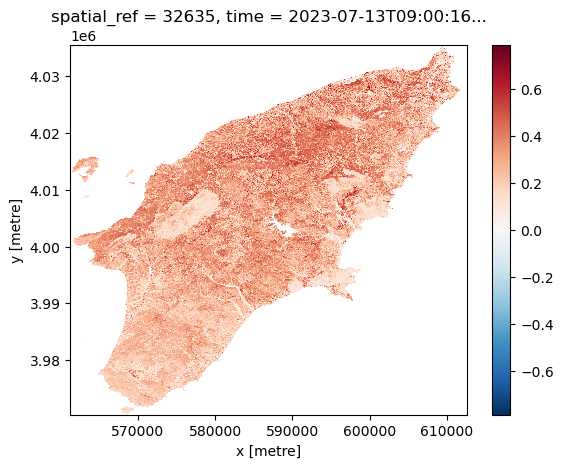

In [14]:
ndvi.sel(time="2023-07-13").plot()

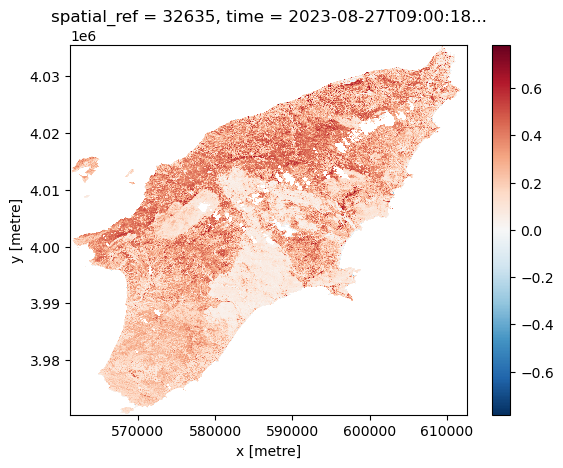

In [15]:
ndvi.sel(time="2023-08-27").plot()

Let's now select a point in the region scorched by wildfires:

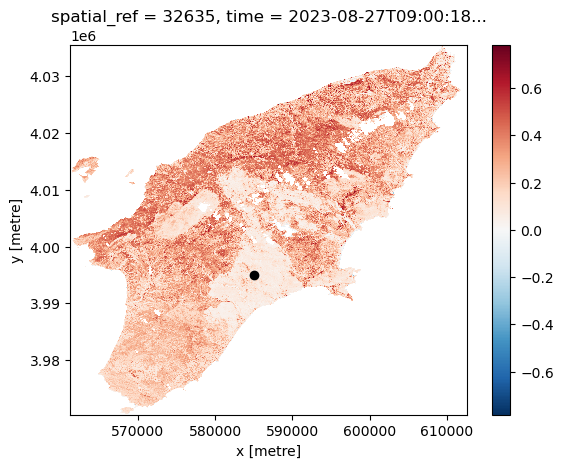

In [16]:
x = 585_000
y = 3_995_000

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ndvi.sel(time="2023-08-27").plot(ax=ax)
ax.scatter(x, y, marker="o", c="k")

Let us extract the NDVI value computed at that point for the full time series:

In [19]:
ndvi_xy = ndvi.sel(x=x, y=y, method="nearest")
ndvi_xy

<xarray.DataArray (time: 25)> Size: 100B
dask.array<getitem, shape=(25,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    y            float64 8B 3.995e+06
    x            float64 8B 5.85e+05
    spatial_ref  int32 4B 32635
  * time         (time) datetime64[ns] 200B 2023-07-01T09:10:15.805000 ... 20...

We now trigger computation. Note that we run this in parallel (probably not much of an effect here, but definitely helpful for larger calculations):

In [20]:
%%time
ndvi_xy = ndvi_xy.compute(scheduler="threads", num_workers=4)

CPU times: user 15.6 s, sys: 4.9 s, total: 20.5 s
Wall time: 1min 8s


The result is a time series representing the NDVI value computed for the selected point for all the available scenes in the time range. We drop the NaN values, and plot the final result:

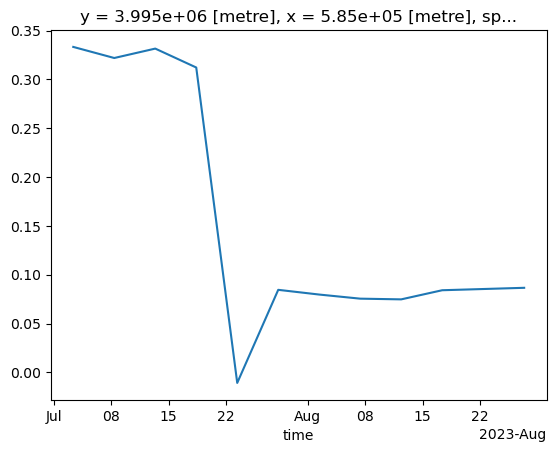

In [21]:
ndvi_xy.dropna(dim="time").plot()